In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())
from statsmodels.stats.weightstats import _zstat_generic

import models
import dre
import rna
from calibrate import rectified_p_value
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

PATH = '/homefs/home/wongfanc/density-ratio-estimation'

True


2024-04-29 21:13:57.509765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 21:13:57.509808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 21:13:57.511000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 21:13:57.517510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 21:13:58.983629: W tensorflow/comp

In [2]:
# load training, calibration, and models
noise_sd = 0.02
p_mut = 4 / 50
n_hidden = 100
n_filters = 32

# load calibration data
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
d = np.load(fname)
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']

# load training data
data_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz'
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

# train ridge regression 
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

# load trained FF and CNN models
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



In [50]:
# sample new designs (only for low n_design)
# need viennaenv for this cell
reload(designers)

n_design = 2000
seed_seq = rna.RNABinding.SEEDS[3]
max_mu = 2
temperatures = [0.05, 0.03, 0.02, 0.01, 0.005]
n_trust_radius_mutations = 5
n_step = 2000
print_every = 500
model_name = 'ridge'

model = name2model[model_name]
biswas = designers.Biswas(model, trainseq_n)
landscape = rna.RNABinding(noise_sd=noise_sd)
name2designdata = {}

for temp in temperatures:
    temp = round(temp, 4)

    designseq_n, _, _ = biswas.design_sequences(
        n_design,
        seed_seq,
        max_mu,
        temp,
        n_trust_radius_mutations,
        n_step,
        print_every
    )
    
    preddesign_n = model.predict(designseq_n)
    ydesign_n = landscape.get_fitness(designseq_n)
    
    name2designdata['biswas-{}-{}'.format(model_name, temp)] = (designseq_n, ydesign_n, preddesign_n)
    
    print('temp = {:.3f}, mean prediction {:.3f}, mean label {:.3f}'.format(
        temp, np.mean(preddesign_n), np.mean(ydesign_n)
    ))


Initialization. Mean, SD prediction: 0.286, 0.027.
Step 500. Mean, SD acceptance probability: 0.080, 0.255. Mean, SD prediction: 0.310, 0.034. (77 s)
Step 1000. Mean, SD acceptance probability: 0.075, 0.249. Mean, SD prediction: 0.313, 0.036. (155 s)
Step 1500. Mean, SD acceptance probability: 0.080, 0.256. Mean, SD prediction: 0.317, 0.038. (233 s)
Step 2000. Mean, SD acceptance probability: 0.087, 0.266. Mean, SD prediction: 0.320, 0.040. (311 s)
temp = 0.050, mean prediction 0.320, mean label 0.303
Initialization. Mean, SD prediction: 0.285, 0.025.
Step 500. Mean, SD acceptance probability: 0.083, 0.256. Mean, SD prediction: 0.321, 0.032. (77 s)
Step 1000. Mean, SD acceptance probability: 0.079, 0.249. Mean, SD prediction: 0.327, 0.035. (156 s)
Step 1500. Mean, SD acceptance probability: 0.076, 0.243. Mean, SD prediction: 0.331, 0.038. (234 s)
Step 2000. Mean, SD acceptance probability: 0.081, 0.250. Mean, SD prediction: 0.336, 0.039. (311 s)
temp = 0.030, mean prediction 0.336, mea

In [51]:
name2designdata['train'] = (trainseq_n + calseqs_n, np.hstack([ytrain_n, ycal_n]), None)

biswas-ridge-0.05 2000
biswas-ridge-0.03 2000
biswas-ridge-0.02 2000
biswas-ridge-0.01 2000
biswas-ridge-0.005 2000
train 10000


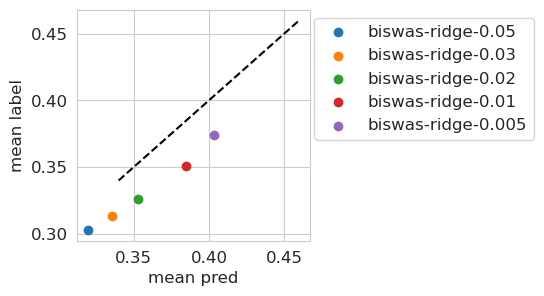

In [52]:
# scatter mean prediction vs. mean label
plt.figure(figsize=(3, 3))
for name, data in name2designdata.items():
    print(name, len(data[0]))
    if name != 'train':
        plt.scatter(np.mean(data[2]), np.mean(data[1]), label=name)
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.legend(bbox_to_anchor=(2, 1))
plt.plot([0.34, 0.46], [0.34, 0.46], '--k');

In [4]:
# 04/18 checking progress of Biswas radius 5 designs
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-biswas-041824.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
for name, data in name2designdata.items():
    print(name, data[1].size)

biswas-ridge-0.05 50000
biswas-ridge-0.03 50000
biswas-ridge-0.02 50000
biswas-ridge-0.01 50000
biswas-ridge-0.005 50000
biswas-ff-0.05 50000
biswas-ff-0.03 50000
biswas-ff-0.02 50000
biswas-ff-0.01 50000
biswas-ff-0.005 50000
biswas-cnn-0.05 50000
biswas-cnn-0.03 50000
biswas-cnn-0.02 50000
biswas-cnn-0.01 50000
biswas-cnn-0.005 50000


In [25]:
# 04/24: checking progress of n_step = 1000 Biswas
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-biswas-042424.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

for name, data in name2designdata.items():
    print(name, len(data[0]))

biswas-ridge-0.05 50000
biswas-ridge-0.03 50000
biswas-ridge-0.02 50000
biswas-ridge-0.01 50000
biswas-ridge-0.005 50000
pex-ridge 50000
biswas-ff-0.05 50000
biswas-ff-0.03 50000
biswas-ff-0.02 50000
biswas-ff-0.01 50000
biswas-ff-0.005 50000
pex-ff 50000
biswas-cnn-0.05 50000
biswas-cnn-0.03 50000
biswas-cnn-0.02 50000
biswas-cnn-0.01 50000
biswas-cnn-0.005 50000
pex-cnn 50000


biswas-ridge-0.05 50000 0.3143555735788161
biswas-ridge-0.03 50000 0.32787711785050155
biswas-ridge-0.02 50000 0.3429419986084979
biswas-ridge-0.01 50000 0.37275817409756884
biswas-ridge-0.005 50000 0.39029802596035174
biswas-ridge-0.015 50000 0.35326043173516153
train 10000 None


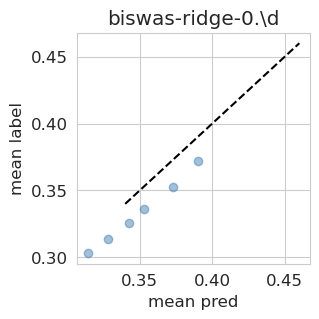

In [3]:
# load pre-sampled and pre-labeled designs!
design_pkl_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-041124-copy.pkl'
regex_str = 'biswas-ridge-0.\d'
regex = re.compile(regex_str)

name2color = {
    'ridge': 'steelblue',
    'ff': 'orange',
    'cnn': 'green'
}
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)
    
name2designdata = {
    name: data for name, data in name2designdata.items()
    if regex.match(name) is not None
}
name2designdata['train'] = (trainseq_n + calseqs_n, np.hstack([ytrain_n, ycal_n]), None)
    
plt.figure(figsize=(3, 3))
for name, data in name2designdata.items():
    print(name, len(data[0]), np.mean(data[2]) if name != 'train' else None)
    if name != 'train':
        for n, color in name2color.items():
            if n in name:
                break
        plt.scatter(np.mean(data[2]), np.mean(data[1]), c=color, alpha=0.5)
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.plot([0.34, 0.46], [0.34, 0.46], '--k');
plt.title(regex_str);

Fitting MDRE for biswas-ridge-0.\d, which has 6 design algorithms:
train
biswas-ridge-0.05
biswas-ridge-0.03
biswas-ridge-0.02
biswas-ridge-0.01
biswas-ridge-0.005
biswas-ridge-0.015
One-hot-encoding all 7 categories of sequences...
  Done. (4 s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.35it/s]


Min train loss 1.34, min val loss 1.33



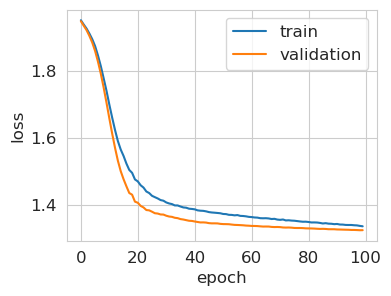

In [5]:
# DRE
reload(dre)
n_hidden = 500
n_epoch = 100
lr = 1e-3
device = torch.device('cuda')

# 'adalead-ridge-0.[0-9]{2}$'
# 'biswas-ridge-0.*[0|1|3|5]$'
# 'biswas-ridge-0.*[0|2|4|8]'
mdre_group_regex_strs = [
    'biswas-ridge-0.\d',
]

mdre = dre.MultiMDRE(
    mdre_group_regex_strs,
    device=device
)

mdre.fit(
    name2designdata,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    verbose=True
)
loss_df = mdre.idx2lossdf[0]

# mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
#     50,
#     len(name2designdata.keys()),
#     n_hidden,
#     device=device
# )
# loss_df = mdre.fit(
#     name2designdata,
#     n_epoch,
#     lr=lr,
#     verbose=True
# )

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
# plt.ylim([0.5, 1.8]);

In [6]:
# point estimates
model_name = 'ridge'
alpha = 0.1
target_values = np.arange(0.3, 0.51, 0.01)

# get DRs for each design distribution
designname2dr = {
    name: mdre.get_dr(calseqs_n, name, self_normalize=True)
    for name in name2designdata.keys() if name != 'train'
}
# designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
imp_target2name = {val: [] for val in target_values}
pp_target2name = {val: [] for val in target_values}
pointest_mx3 = np.zeros([len(name2designdata), 3])
ciwidth_mx2 = np.zeros([len(name2designdata), 2])
model = name2model[model_name]

for i, data in enumerate(name2designdata.items()):
    
    design_name, (designseq_n, ydesign_n, preddesign_n) = data
    
    if design_name != 'train':
        print(design_name)
        
        imputed_mean = np.mean(preddesign_n)
        imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)
        
        caldr_n = designname2dr[design_name]
        predcal_n = model.predict(calseqs_n)
        rect_n = caldr_n * (ycal_n - predcal_n)
        rectifier_mean = np.mean(rect_n)
        rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
        pointest_mx3[i] = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)
        
        pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
        ciwidth_mx2[i] = pp_se, imputed_se

        print('{:.3f} {:.3f} {:.3f}'.format(
            np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
        ))
        
        for target_val in target_values:

            # run imputation hypothesis test
            imp_pval = _zstat_generic(
                imputed_mean,
                0,
                imputed_se,
                alternative='larger',
                diff=target_val
            )[1]

            # run prediction-powered hypothesis test
            pp_pval = rectified_p_value(
                rectifier_mean,
                rectifier_se,
                imputed_mean,
                imputed_se,
                null=target_val,
                alternative='larger'
            )

            # Bonferroni correction
            if imp_pval < alpha / (len(name2designdata) - 1):
                imp_target2name[target_val].append(design_name)
                
            if pp_pval < alpha / (len(name2designdata) - 1):
                pp_target2name[target_val].append(design_name)
    else:
        train_idx = i
pointest_mx3 = np.delete(pointest_mx3, train_idx, axis=0)
ciwidth_mx2 = np.delete(ciwidth_mx2, train_idx, axis=0)

biswas-ridge-0.05
0.303 0.314 0.310
biswas-ridge-0.03
0.314 0.328 0.323
biswas-ridge-0.02
0.326 0.343 0.337
biswas-ridge-0.01
0.353 0.373 0.361
biswas-ridge-0.005
0.372 0.390 0.367
biswas-ridge-0.015
0.336 0.353 0.346


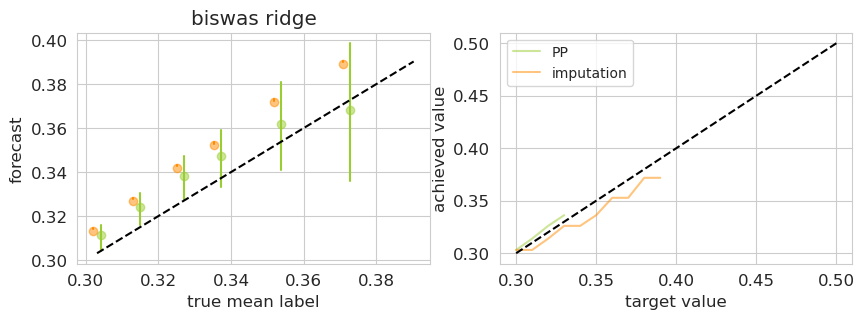

In [7]:
# run preliminary selection experiments and plot
title = f'biswas {model_name}'
ppoff = 0.001
impoff = -0.001

impach_t = []
ppach_t = []
xy_lim = [np.min(target_values), np.max(target_values)]

for val in target_values:
    names = imp_target2name[val]
    imp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(imp_truemeans):
        impach_t.append(np.min(imp_truemeans))
    else:
        impach_t.append(np.nan)
    
    names = pp_target2name[val]
    pp_truemeans = [np.mean(name2designdata[name][1]) for name in names]
    if len(pp_truemeans):
        ppach_t.append(np.min(pp_truemeans))
    else:
        ppach_t.append(np.nan)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_mx3[:, 0] + ppoff, pointest_mx3[:, 1] + ppoff, label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_mx3[:, 0] + impoff, pointest_mx3[:, 2] + impoff, label='imputation', c='darkorange', alpha=0.5) 
for pe_x3, ciw_x2 in zip(pointest_mx3, ciwidth_mx2):
    plt.plot([pe_x3[0] + ppoff, pe_x3[0] + ppoff], [pe_x3[1] - 2 * ciw_x2[0], pe_x3[1] + 2 * ciw_x2[0]], c='yellowgreen')
    plt.plot([pe_x3[0] + impoff, pe_x3[0] + impoff], [pe_x3[2] - 2 * ciw_x2[1], pe_x3[2] + 2 * ciw_x2[1]], c='darkorange')

plt.plot([np.min(pointest_mx3), np.max(pointest_mx3)], [np.min(pointest_mx3), np.max(pointest_mx3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppach_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impach_t, label='imputation', c='darkorange', alpha=0.5)
plt.plot(xy_lim, xy_lim, '--k');
plt.xlabel('target value');
plt.ylabel('achieved value');
plt.legend(fontsize=10);

